## Efficiently Learn Latent Number Lines with CNL

For a more detailed look, check out the following paper published in IEEE: [Representing Latent Dimensions Using Compressed Number Lines](https://ieeexplore.ieee.org/document/10190998)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](TODO PUT LINK HERE)

In [ ]:
# TODO: optional magic to install the sith library 

In [1]:
from sith.cnl import CNL
from sith.dataset_utils import dataloader, pad_sequence, random_split

import jax
import jax.numpy as jnp
import jax.random as jrandom
import optax
import equinox as eqx

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [36]:
def odometer_data(dataset_size, distance):
    inputs = []
    targets = []
    
    for i in range(dataset_size):
        curr_distance = 0
        step_sizes = []

        while curr_distance < distance:
            step_size = np.random.uniform(low=0, high=3, size=(2,))
            curr_distance += np.sum(step_size)
            
            step_sizes.append(step_size)

        # adjust the final step to match the distance
        if curr_distance > distance:
            step_sizes[-1][0] -= curr_distance - distance

        # add some extra steps after the distance is reached
        # to make the problem harder
        n_extra_steps = 50
        
        for i in range(n_extra_steps):
            step_size = np.random.uniform(low=0, high=3, size=(2,))

            curr_distance += step_size
            step_sizes.append(step_size)
        
        input = np.array(step_sizes)  
        target = np.zeros(len(step_sizes))
        target[-n_extra_steps] = 1. # this is where we hit the target distance

        inputs.append(input)
        targets.append(target)

    return np.swapaxes(pad_sequence(inputs, pad_start=False), 1, 2), pad_sequence(targets, pad_start=False)

In [26]:
# Many animals have an impressive ability to integrate information over time.
# For example, dead reckoning ants TODO. What kind of neural architecture supports this?
# The answer is SITH, of course!

# Here's a toy problem to see how this might work in practice:
# A particular brand of car needs an oil change the first 100 miles after driving off the lot,
# but the car computer only has sensor inputs that track the car's (2-D) velocity.
# How can the car computer predict when the car will hit its 100 miles?

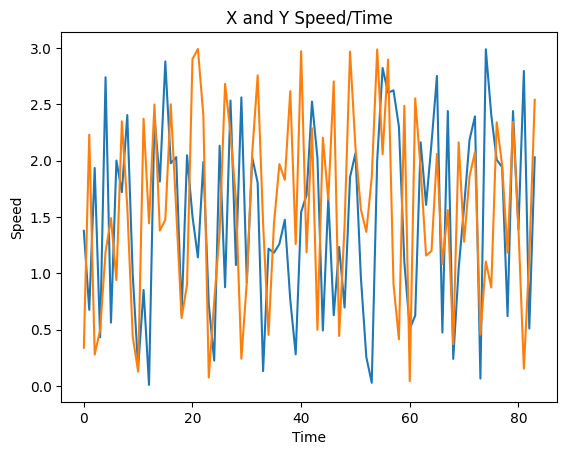

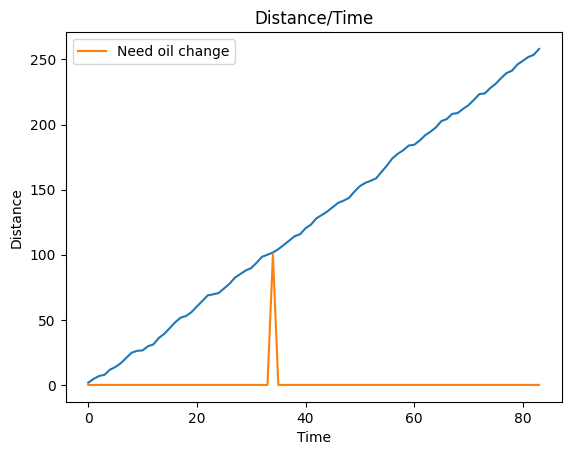

In [37]:
# Let's take a look at an example observation:
sensors, target = odometer_data(dataset_size=1, distance=100)
sensors, target = sensors.squeeze(), target.squeeze()

plt.plot(sensors.T)
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('X and Y Speed/Time')
plt.show()

plt.plot(np.cumsum(sensors[0] + sensors[1]))
plt.plot(target*100, label='Need oil change')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.title('Distance/Time')
plt.legend();

In [41]:
# SITH is very good at integrating information over time, so to make things
# harder, we'll modulate the signal such that SITH will not observe raw velocity.

inputs, targets = odometer_data(dataset_size=100, distance=100)

print(inputs.shape)
print(targets.shape)

inputs *= np.array([2., -3.7])[None, :, None]
inputs += 4

train_inputs, train_targets, test_inputs, test_targets = random_split(inputs, targets, train_proportion=.7)

(100, 2, 90)
(100, 90)


In [5]:
# Hyperparameters
BATCH_SIZE=10
LEARNING_RATE=3e-3
STEPS=100
SEED=5678

key = jrandom.PRNGKey(SEED)

cnl = CNL(in_size=2, 
          sith_params={'tau_min': .5,
                       'tau_max': 200,
                       'n_taus': 100}, 
          key=key)

In [6]:
optim = optax.adam(LEARNING_RATE)
opt_state = optim.init(eqx.filter(cnl, eqx.is_array))

In [7]:
@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    batch_size, seq_len = y.shape
    
    pred_logits = jax.vmap(model)(x)

    weights = jnp.where(y == 0, 1.0 / seq_len, 1.0)
    weighted_cross_entropy = optax.sigmoid_binary_cross_entropy(pred_logits, y)*weights

    return jnp.mean(jnp.sum(weighted_cross_entropy, axis=1))


@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    return loss, model, opt_state

In [8]:
iter_data = dataloader((train_inputs, train_targets), BATCH_SIZE)

losses = []

for step, (x, y) in tqdm(zip(range(STEPS), iter_data)):
    loss, cnl, opt_state = make_step(cnl, x, y, opt_state)
    losses.append(loss.item())

0it [00:00, ?it/s]

100it [00:01, 60.54it/s] 


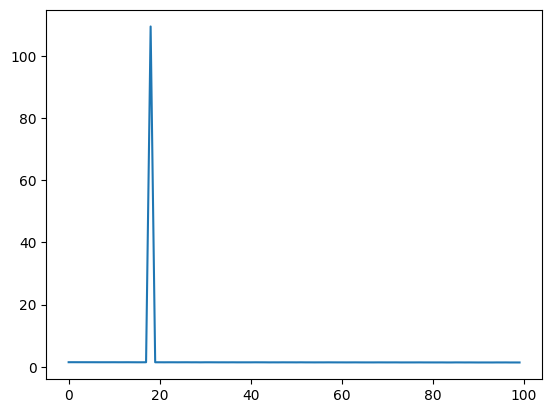

In [9]:
plt.plot(losses)

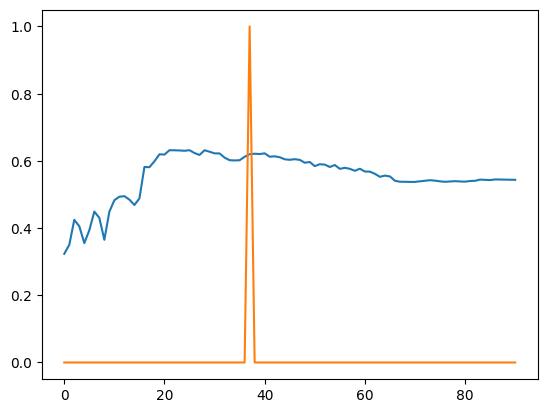

In [10]:
i = 0
plt.plot(jnp.exp(cnl(test_inputs[i])))
plt.plot(test_targets[i])